In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, date
import random

## Python Roboadvisor
### Max Cheng, Nathan Chu, Rahim Merchant, Matthew Yang

# **Objective**
Given a list of unknown stock tickers, generate a realistic portfolio that deviates in nominal value the least amount possible, specifically from November 28th to December 2nd, 2022, but with a longer term perspective in mind.

Expected Runtime: 5 minutes (on Google Collaboratory)

# **Introduction**

> "*In theory, theory and practice are the same. In practice, they are not.*" - Albert Einstein

In theory, the stock prices of oil companies and airline companies are negatively correlated, as oil companies generate more revenue while airlines incur more expenses with rising oil prices. In theory, gold is inversely related to equity securities, as it is seen as a safe asset in times of turmoil in the stock market. In theory, companies whose quarterly earnings beat the expectations of Wall Street analysts rise in value, while those who disappoint decline. 

In practice, financial securities in recent years are becoming increasingly correlated. Systematic risk is having a much larger effect on price action than idyosyncratic risk. More often than not, the movement of the overall market seems to influence a company's stock price more than that company's performance. In light of this, how can we dynamically identify the stocks and allocations that will create a portfolio unphased by market movements? The answer is the culmination of the lectures of Professor James Thompson, the tutorials of numerous teaching assistants, and the fruits of the dozens of hours of labour invested by four freshmen CFM students.

# **1: Setup**
First, we initialize some noteable constants and variables and turn the csv file containing the candidate tickers for our portfolio into a list of strings.

In [2]:
# The amount (in USD) that we have to spend
capital = 500000

# The amount of stocks we intend to purchase
number_of_stocks = 25

# The maximum and minimum weightings of each stock in our portfolio
min_weight = 1 / (2 * number_of_stocks)
max_weight = 0.25

# Final output in Jupyter Notebook
Portfolio_Final = pd.DataFrame()

# Final output in .csv file
Stocks_Final = pd.DataFrame()

# The date at which we are making all purchases
# Note that this is one day after the true buy date because of the way yfinance 
# handles datetime parameters
buy_date = '2022-11-26'

# Some restrictions on permissible stocks
currency = "USD"
min_days = 20
min_avg_volume = 200000

In [3]:
ticker_lst = pd.read_csv("Tickers.csv", header=None)[0].tolist()
print(ticker_lst)

['AAPL', 'ABBV', 'ABT', 'ACN', 'AGN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CELG', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PCLN', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTN', 'RY.TO', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TD.TO', 'TGT', 'TWX', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


# **2: Filter**

Before proceeding with a safe portfolio strategy, we must create a function called filter that goes through each stock in "Tickers_csv," produces a list of valid tickers and meets the following requirements:
- Is listed on an American stock exchange
- Has an average monthly volume of 200,000, excluding months with less than 20 trading days

The filter function starts with an empty list called good_stocks, filters out the delisted and non-USD-listed stocks, and appends the listed and USD-listed stocks to good_stocks.

We then iterate through each stock in good_stocks and remove the months that contain less than 20 days by looking at the number of trading days each month from January 01, 2022, to October 31. Since stocks on the NYSE and NASDAQ have identical trading days, looking at the number of days in each month that we have Adjusted Close prices for an index such as the S&P 500 will suffice. Next, we append the months that contain less than 20 days in an empty list called short_months and drop those months for each stock's data frame. 

Once we drop the months with less than 20 days, we calculate the average monthly volume, and if it is less than 200,000, we remove those stocks from good_stocks. 

The final list of tickers in good_stocks is the tickers that meet the requirements and are used in creating the safe portfolio. 

All tickers that are removed are marked down with their indicated reason.

In [4]:
filter_start_date = "2022-01-01"
filter_end_date = "2022-10-31"

def filter_stocks(ticker_list):
    good_stocks = []
    stock_data = []
    
    # Remove all invalid tickers or tickers not listed on a US Market
    # Save the permissible tickers to good_stocks
    for ticker in ticker_list:
        try:
            if yf.Ticker(ticker).info["financialCurrency"] == currency:
                good_stocks.append(ticker)
            else:
                print(f"{ticker} is not American")
        except:
            print(f"{ticker} is not a valid ticker (might be delisted)")
    
    # Generate stock history corresponding to each stock
    for stock in good_stocks:
        stock_data.append(yf.Ticker(stock).history(start=filter_start_date, end=filter_end_date, interval="1mo").dropna())
    
    # Calculate months with less than 20 trading days on a US Exchange
    short_months = []
    market_index = yf.Ticker('^GSPC')
    for month in range(1,11):
        length = len(market_index.history(start = str(date(2022, month, 1)) , end = str(date(2022, month+1, 1))))
        if length < min_days:
            short_months.append(month)

    # Remove all months with less than 20 trading days from monthly volume data
    for stock_df in stock_data:
        for month in short_months:
            stock_df.drop(str(date(2022, 2, 1)))
    
    # Remove all stocks with less than 200,000 in monthly volume
    for i in range(len(stock_data)):
        if stock_data[i].Volume.mean() < min_avg_volume:
            print(f"{good_stocks[i]} does not meet volume requirements")
            good_stocks.remove(good_stocks[i])
    
    return good_stocks
    
filtered_tickers = filter_stocks(ticker_lst)

- AGN: No summary info found, symbol may be delisted
AGN is not a valid ticker (might be delisted)
- CELG: No summary info found, symbol may be delisted
CELG is not a valid ticker (might be delisted)
PCLN is not a valid ticker (might be delisted)
- RTN: No summary info found, symbol may be delisted
RTN is not a valid ticker (might be delisted)
RY.TO is not American
TD.TO is not American
TWX is not a valid ticker (might be delisted)


# **3: Stock Selection**

At the lowest level, a financial portfolio is a list of financial securities being held and the proportion of the entire portfolio that each security makes up. In this step, we will produce three candidate lists of stocks for our portfolio, and in the next step, we will determine the optimal proportions for each of these lists and compare the historical performance of the resulting portfolios.

The first step in selecting our stocks is downloading stock data for each of the stocks in our filtered list. We decided on a time period for analysis of January 1st, 2018 to the date at which the portfolio is being purchased for the following reasons:
1. Keeping in mind the long-term objective of our portfolio, we want to know how these stocks behaved in different macroeconomic environments. How reslient were they in the market sell-off of February-March 2020? How did they perform in times of low interest rates (March 2020 - March 2022) versus rising interest rates (March 2022 - Present)? Questions like these are better answered with more historical data.
2. Keeping in mind the evolution of companies, we want to avoid analyzing the price action of stocks that are fundamentaly different today. For many decades, Apple traded like a startup company with volatile prices. Today, Apple is the largest company in the world in terms of market capitalization and trades like a blue chip stock. Thus we can make better predictions about Apple's future price actions with more recent historical data.

So the choice of January 2018 was a compromise between the benefits and drawbacks of using more recent data versus more data overall. Note that we also resampled the daily returns into weekly returns to improve computational efficiency in later steps.

In [5]:
# Setting dates
start_date = '2018-01-01'
end_date = buy_date 

# Downloading data for stocks
data = yf.download(tickers = filtered_tickers,
                   start=start_date,
                   end=end_date)

# Stores weekly returns for each stock in a dataframe                   
weekly_returns = data['Adj Close'].resample('W').ffill().pct_change()
weekly_returns.drop(index=weekly_returns.index[0], inplace=True)

weekly_returns.head()

[*********************100%***********************]  55 of 55 completed


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-14,0.011943,-0.000497,0.002227,0.015475,0.005276,0.061881,-0.001088,0.088622,0.028355,-0.019095,...,0.059375,-0.041471,-0.015700,-0.015472,0.154020,0.032991,-0.000393,0.026466,0.050697,0.030007
2018-01-21,0.007736,0.042854,0.007988,0.010243,0.009513,-0.008137,-0.029117,0.004521,0.016993,0.019229,...,-0.019880,-0.008921,-0.007673,0.008401,0.016927,0.036462,0.064337,0.000567,-0.007532,-0.009126
2018-01-28,-0.038944,0.177466,0.069297,0.004946,0.050853,0.083015,0.016322,0.016256,0.015132,0.074472,...,0.015572,-0.002925,-0.003227,0.016394,-0.014725,-0.026876,0.021040,-0.049699,-0.002705,0.029224
2018-02-04,-0.064195,-0.065255,-0.027279,-0.034759,-0.025356,0.019899,-0.029610,0.016578,-0.007764,-0.065451,...,-0.050509,-0.003160,-0.043919,0.006610,-0.051982,-0.047798,-0.066769,-0.036281,-0.122438,-0.020823
2018-02-11,-0.021510,-0.033602,-0.073270,-0.019503,-0.044733,-0.063184,-0.051303,-0.041378,-0.050704,-0.078673,...,-0.109105,0.003622,0.004344,-0.053060,-0.006854,-0.066599,-0.047093,-0.016079,-0.086546,-0.055360


## 3.1: Measuring Standard Deviation

Movement in the value of a portfolio is caused by changes in price from its underlying securities. Thus the most straightforward (although not necessarily the most effective) way to create a portfolio with minimal price fluctuations is to choose individual stocks with minimal price fluctuations. 


In statistics, we use **standard deviation**, or $\sigma_{i}$, to measure the spread of a set of data points relative to its mean. The formula is outlined below, where $x_{i}$ is a single data point, $\overline{X}$ is the arithmetic mean of the data points, and $N$ is the number of data points in our dataset.

\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

In our case, the data points are the weekly historical returns of the stocks that we just downloaded and the arithmetic mean is referred to as expected return. To further standardize the metrics for stocks with different share prices, we will be looking at *percentage changes* in share price, since a percentage change takes a proportion of the stock. 

The following function calculates the standard deviation of weekly historical returns for each stock, then returns that list of stocks sorted from lowest to highest standard deviation.

In [6]:
# A function used to create a list of stocks with the lowest standard deviation of weekly returns
def low_std_stocks(tickerlst, weekly_returns):
    # Initializing a new empty list to store the stocks
    lstd_stocks = []
    # Calculate the standard deviations of the weekly returns from the given dataframe
    weekly_returns_std = pd.DataFrame(np.std(weekly_returns))
    weekly_returns_std.columns = ['std']
    # Sort the std values so that we can access the lowest std stocks easier
    weekly_returns_std.sort_values(by='std', inplace=True)

    # Checks to see if the stock is already used inside tickerlst which will be the list of paired up stocks
    for i in weekly_returns_std.index:
        if(i not in tickerlst):
            lstd_stocks.append(i)
    return lstd_stocks

# 3.2: Measuring Correlation

In our introduction, we mentioned correlations between stocks. Let's quantify this before proceeding any further. 

To calculate correlation, we first find the covariance of two variables. Covariance gives us insight into how changes in two variables are statistically related. Note the similarities between this formula and the formula for standard deviation.

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

Correlation standardizes covariance by dividing by the product of the standard deviations of the two data sets. It represents the degree to which movements in one variable are reciprocated by movements in the other variable. A correlation of $1$ occurs when both variables are moving in tandem, and we call this perfect correlation. A correlation of $-1$ occurs when the relationship between the two variables is always exactly opposite to each other, and we call this perfect negative correlation. Correlation allows us to compare apples to apples the correlations of any pair of stocks with any other pair.

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

In theory, we would love to own a pair of stocks with a correlation of $-1$, since no matter how volatile they are, price movements in one stock are negated by price movements in the other direction of the second stock, and our portfolio does not change in value. But what about a $-0.5$ correlation? Well that would mean a movement of $\$1$ in one stock will be matched by a movement of $\$0.50$ in the opposite direction by the other stock, and vice versa. But if we own these stocks at a ratio of $1:2$, our theoretical portfolio value will still not fluctuate! This idea applies for any two stocks that have a negative correlation.

"But didn't you just say everything was positively correlated in the introduction?" Yes, dear reader, we did say that, and it certainly does seem that way. However, through experimentation with many different tickers, we found that some small-cap stocks and publicly-listed holding companies do in fact have negative correlations with other stocks. Thus our second strategy for selecting stocks is to compare the correlations of each possible pairing of stocks from the filtered list, and to select the pairs that have the lowest correlations.

In [7]:
# Create a correlation matrix of all individual stocks against each other
corr_pairs = weekly_returns.corr()

# Reformatting the correlation matrix for easier data manipulation
corr_pairs['Stock 1'] = corr_pairs.index
corr_pairs = corr_pairs.melt(id_vars='Stock 1', var_name='Stock 2').reset_index(drop=True)
corr_pairs.rename(columns = {'value' : 'Correlation'}, inplace=True)
corr_pairs.head()

,Stock 1,Stock 2,Correlation
0,AAPL,AAPL,1.000000
1,ABBV,AAPL,0.409263
2,ABT,AAPL,0.479455
3,ACN,AAPL,0.613495
4,AIG,AAPL,0.340470


In [8]:
# A function to find the least correlated pairs of stocks and return a list of those stocks
def pairing(correlations, cnt, acc, pairs, tickerlst):

  # Made a copy of the original correlation matrix dataframe to make recursive calls on
    temp = correlations.copy()

    # Checks whether or not the number of pairs provided as an argument has been met
    if(acc == cnt):
        return tickerlst

    # Initializing the minimum correlation value and stock names
    min = 1
    s1 = ""
    s2 = ""

    # Loops through the correlation matrix dataframe to find the minimum correlation value and then stores
    # the minimum value and the names of the stocks
    for index, rows in temp.iterrows():
        if(rows['Correlation'] <= min):
            min = rows['Correlation']
            s1 = rows['Stock 1']
            s2 = rows['Stock 2']

    # Adds each individual stock from each pair into a list of all the paired up tickers
    tickerlst.append(s1)
    tickerlst.append(s2)

    # Loops through the correlation matrix and removes any row that contains the stock name of already paired up stocks
    for index, rows in temp.iterrows():
        if((s1 == rows['Stock 1']) or (s2 == rows['Stock 1']) or (s1 == rows['Stock 2']) or (s2 == rows['Stock 2'])):
            temp.drop(index, inplace=True)
    acc += 1

    # Makes a recursive call on the function to find the next most optimal pair for the portfolio
    pairing(temp, cnt, acc, pairs, tickerlst)
    return tickerlst

# 3.3: Choosing Candidates
One of the restrictions for this project is that our portfolio must hold shares of at least 12 and at most 25 unique companies. As we learned in CFM101, diversification tends to reduce the volatility of a portfolio, which happens the be the ultimate goal for this portfolio. Thus we will not even be considering generating portfolios of stocks with any less than 25 unique companies. 

- The first list of 25 stocks, all_lstd, is created by taking the 25 stocks from our filtered list with the lowest standard deviation.

- The second list, all_pairing, is created by taking the 12 pairs of stocks (so 24 unique stocks) with the lowest correlations, plus the lowest standard deviation stock that isn't already in one of the 12 pairs for an even (or should I say odd) list of 25.

- The final list, combined_stocks, is created by taking the 6 pairs of stocks with the lowest correlations, plus the 13 lowest standard deviation stocks that are not already in the 6 pairs.

The reason for three different lists is we cannot be sure how many stocks in the ticker list that we will receive will be negatively correlated with each other. If there are many, then we would expect the all_pairing portfolio to be less volatile. If there are few, then all_lstd would be less volatile. In the next step, we will see how well these combinations of stocks withstood the test of time and choose the best list to create our final portfolio with!

In [9]:
# Storing our three different lists of stocks into variables that we can use in the allocation section
# by using a combination of the low_std_stocks function and the pairing function

# Builds a list of 25 stocks which are chosen solely based on the lowest standard deviation of their weekly returns
all_lstd = low_std_stocks([], weekly_returns)[0:25]

# Builds a list of 25 stocks 24 of which are chosen solely based on having the lowest correlation value with another stock
# against all other possible pairs of stocks and 1 of which is chosen based on having the lowest standard deviation of
# weekly returns that is not already paired up with another stock
all_pairing = pairing(corr_pairs, 12, 0, {}, [])
all_pairing.append(low_std_stocks(all_pairing, weekly_returns)[0])

# Builds a list of 25 stocks 12 of which are chosen solely based on having the lowest correlation value with another stock
# against all other possible pairs of stocks and 13 of which are chosen based on having the lowest standard deviation of
# weekly returns that is not already paired up with another stock
combined_stocks = pairing(corr_pairs, 6, 0, {}, [])
combined_stocks += (low_std_stocks(combined_stocks, weekly_returns)[0:13])

print("Lowest STD Portfolio: ", all_lstd, sep='')
print("Pairing Portfolio: ", all_pairing, sep='')
print("Hybrid Portfolio: ", combined_stocks, sep='')

Lowest STD Portfolio: ['MON', 'CL', 'PG', 'PEP', 'MRK', 'KO', 'BMY', 'COST', 'MSFT', 'T', 'CMCSA', 'CSCO', 'ORCL', 'PFE', 'TXN', 'ABT', 'SO', 'ACN', 'MO', 'NEE', 'LMT', 'UNP', 'GOOG', 'SBUX', 'PM']
Pairing Portfolio: ['MON', 'PEP', 'ABT', 'SLB', 'AMZN', 'OXY', 'MRK', 'QCOM', 'BIIB', 'SO', 'LLY', 'USB', 'COP', 'COST', 'SPG', 'TGT', 'BMY', 'PYPL', 'BA', 'PFE', 'GOOG', 'MO', 'PM', 'UPS', 'CL']
Hybrid Portfolio: ['MON', 'PEP', 'ABT', 'SLB', 'AMZN', 'OXY', 'MRK', 'QCOM', 'BIIB', 'SO', 'LLY', 'USB', 'CL', 'PG', 'KO', 'BMY', 'COST', 'MSFT', 'T', 'CMCSA', 'CSCO', 'ORCL', 'PFE', 'TXN', 'ACN']


# **4: Allocation Selection**
We are now left with the following question: Given these three lists of 25 stocks, how can we find the list and allocation that will result in the least volatile portfolio? 

After a few days of contemplation and discussion, we decided that implementing a brute force method would be the most reliable strategy. Here is an overview of how we implemented it, to be explained further via comments in the code blocks.
1. Generate a random list of 25 numbers that sum to 1. This represents the weightings of each stock in a hypothetical portfolio.
2. Fetch the historical adjusted close data for the 25 stocks in one of the lists and create a portfolio with the weightings from step 1.
3. Repeat steps 1 and 2 1,500 times and generate a new portfolio with different weightings each time.
4. Calculate the standard deviation of returns for each portfolio and retrieve the stock weightings that produced the portfolio with the lowest standard deviation.
5. Repeat steps 1 through 4 for each of the other two lists of potential stocks, and compare the least volatile portfolio generated out of each of the lists to determine the least volatile portfolio overall.

In [10]:
# Creates a list of allocations/weightings for the portfolio
def generate_allocation(portfolio_size):
    allocation = []

    # Adds a random number to the allocation
    for i in range(portfolio_size):
        n = random.randint(20, 100)
        allocation.append(n)

    allocation_sum = np.sum(allocation)

    # Adjusts the random number to be an allocation out of the total sum
    for j in range(portfolio_size):
        allocation[j] = allocation[j]/allocation_sum

    # Ensuring that the weighting of each stock meets our requirements
    if min(allocation) < min_weight:
        return generate_allocation(portfolio_size)
    elif max(allocation) > max_weight:
        return generate_allocation(portfolio_size)
    else:
        return allocation

In [11]:
# Gets the returns of the stocks given and returns is as a dataframe of % changes
def get_returns(stocks):
    daily_returns = pd.DataFrame()
    temp = pd.DataFrame()

    # Only keeps the close prices columns for each stock
    for stock in stocks:
        daily_returns[stock] = data['Adj Close'].loc[start_date:end_date][stock].dropna()

    weekly_returns = daily_returns.resample('W').ffill()
    return weekly_returns.pct_change().dropna()

In [12]:
# Calculates the return of the portfolio given stocks and weightings
def calculate_return(stocks, returns, allocation):
    portfolio_weekly_return = pd.DataFrame()
    daily_return = 0
    count = 0

    # Calculating weekly return of each stock in the portfolio
    for stock in stocks:
        portfolio_weekly_return[stock] = returns[stock] * allocation[count]
        count += 1

    # Calculating weekly return of the portfolio
    portfolio_weekly_return['Portfolio Return'] = portfolio_weekly_return.sum(axis=1)

    return portfolio_weekly_return['Portfolio Return']

In [13]:
# Draws a scatter plot comparing the risk and return of each portfolio
def plot_performance(portfolio_performance, chart_title):
    # Setting plot size
    plt.subplots(figsize=[12, 12])

    # Plots points
    plt.scatter(portfolio_performance['Risk']*100, portfolio_performance['Expected Return']*100, c='blue')

    # Setting title and labels
    plt.title(f"Weekly Performance of {chart_title}, January 2018 - Present")
    plt.xlabel("Standard Deviation (%)")
    plt.ylabel("Expected Return (%)")

    plt.show()

In [14]:
# Generates a set number of portfolios and returns the least risky one
def generate_portfolios(number_of_portfolios, ticker_lst, chart_title):
    portfolio_performance = pd.DataFrame()
    portfolio_expected_returns = []
    portfolio_risks = []

    weights = []
    weekly_returns = get_returns(ticker_lst)

    # Stores the returns and standard deviation of each created portfolio in a dataframe
    for i in range(number_of_portfolios):
        weights.append(generate_allocation(len(ticker_lst)))
        temp_portfolio = calculate_return(ticker_lst, 
                                        weekly_returns, 
                                        weights[i])
        portfolio_expected_returns.append(np.mean(temp_portfolio))
        portfolio_risks.append(np.std(temp_portfolio))

    portfolio_performance['Expected Return'] = portfolio_expected_returns
    portfolio_performance['Risk'] = portfolio_risks

    # Draws graph of all the portfolios simulated
    plot_performance(portfolio_performance, chart_title)

    # Picks the least risky portfolio based on lowest standard deviation
    least_risky_portfolio = weights[portfolio_performance.loc[portfolio_performance['Risk'] 
                                                          == min(portfolio_performance['Risk'])].index.tolist()[0]]
    return least_risky_portfolio

# 4.1: Generate Portfolios
As we generate random portfolios for each list of stocks, we decided to plot the performance of each of these portfolios on a scatter plot to better visualize the risk-return tradeoff$^{*}$. The risk-return tradeoff states that since investors will always prefer lower risk for a given return and higher return for a given risk level, we expect the potential returns of an investment to increase as the associated risk increases. So by choosing the portfoio with the lowest standard deviation (or lowest risk), we would expect the returns to be more modest, which thinking back to our objective, is in fact desirable.

In the scatter plots for the lowest STD portfolios and the hybrid portfolios (plots 1 and 3), we would expect a positive correlation between expected return and standard deviation of returns. However, in the all pairing portfolio (plot 2), the correlation is much weaker because not too many stocks in the list we were testing were negatively correlated. Instead, some of the pairs of stocks in this portfolio have a correlation near 0, meaning the stocks essentially move independent of each other. If we had more negatively correlated stocks in our list, we would expect the "all pairing" list to produce portfolios with significantly lower standard deviations, but with the list of stocks that we tested on this was not the case.

$^{*}$ More accurately, this scatter plot represents an Efficient Frontier, but this goes beyond the scope of our analysis.

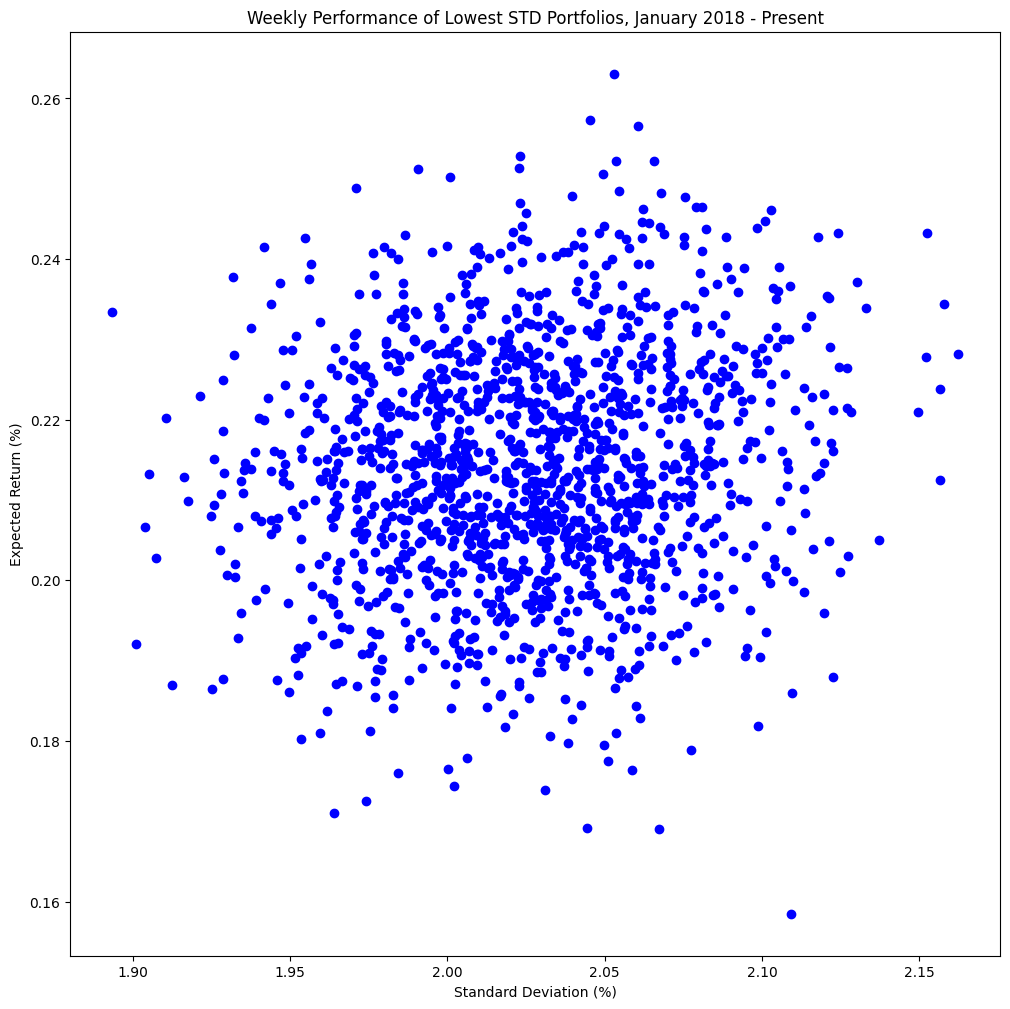

In [15]:
# Generates the least riskiest portfolio where we pick the stocks with the lowest standard deviations 
all_lstd_weightings = generate_portfolios(1500, all_lstd, "Lowest STD Portfolios")

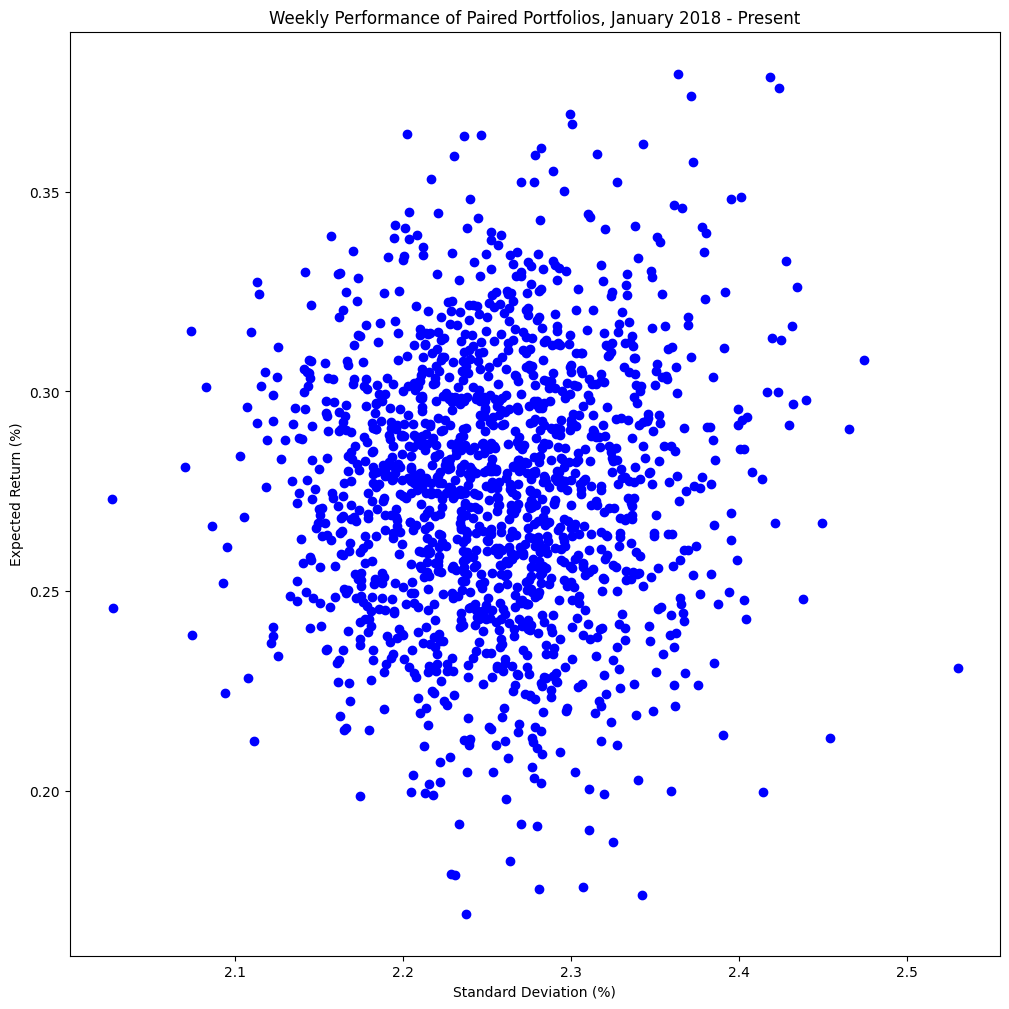

In [16]:
# Generates the least riskiest portfolio where we pick pairs of negatively correlated stocks 
all_pairing_weightings = generate_portfolios(1500, all_pairing, "Paired Portfolios")

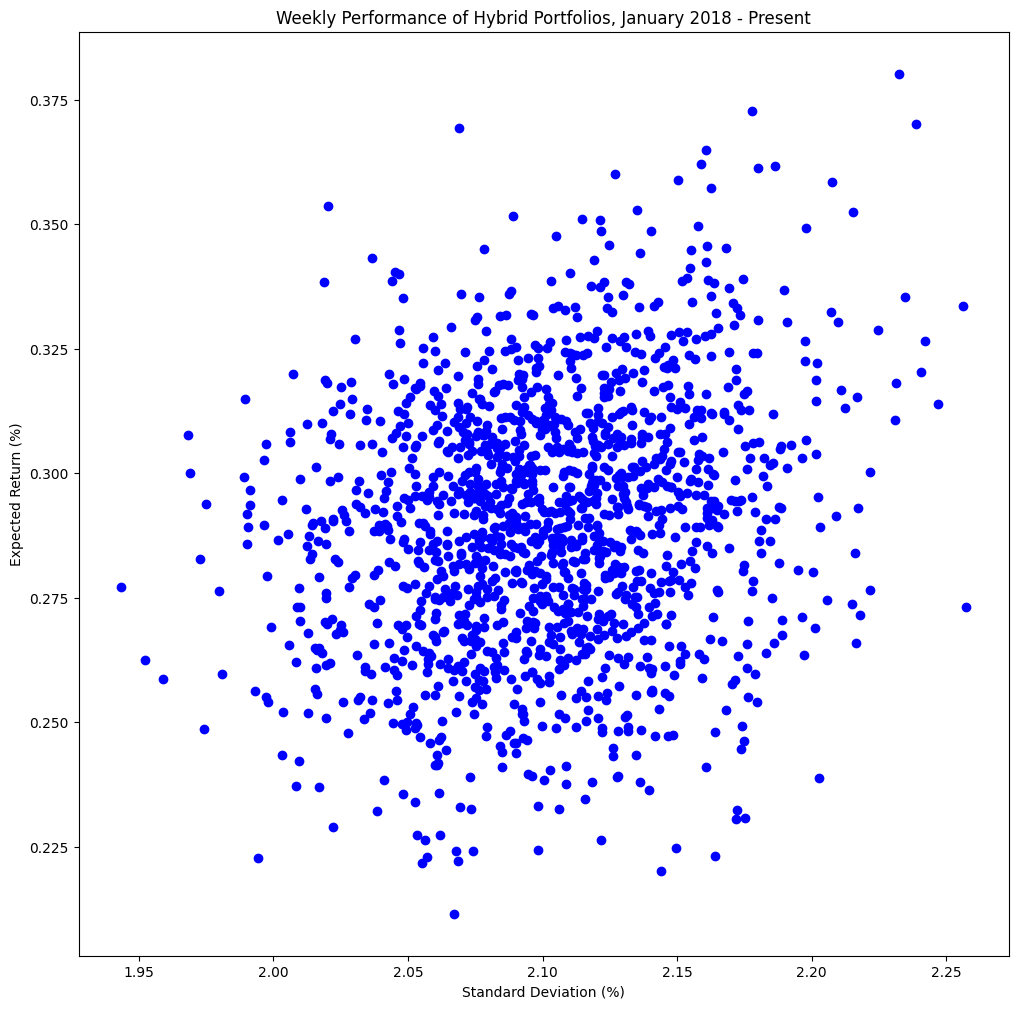

In [17]:
# Generates the least riskiest portfolio where we pick the stocks with a combination of 
# the lowest standard deviations and pairs of negatively correlated stocks 
combined_stocks_weightings = generate_portfolios(1500, combined_stocks, "Hybrid Portfolios")

Looking at each plot, we see that the points with the lowest standard deviation do not necessarily have the lowest returns. This is due to the use of historical prices. Even though some generated portfolios had a lower average weekly return in the given time range, they were riskier (higher standard deviation). A portfolio can experience large fluctuations each week but still have a low expected weekly return because the ups and downs average out. Meanwhile, another portfolio can have consistently high returns each week. Then, it will have a high expected weekly return, but a low standard deviation, as each weekly return is near the mean return. Therefore, theoretically we want a low return and low risk stock, but ideally, we can find a balance between having a low return and a low standard deviation.

Ultimately, we still decided to choose the portfolio with the lowest standard deviation because we believe that the lower volatility will result in returns that are closest to zero.

In [18]:
# Calculates and compares the standard deviations of these least risky portfolios
all_lstd_std = calculate_return(all_lstd, get_returns(all_lstd), all_lstd_weightings).std()
all_pairing_std = calculate_return(all_pairing, get_returns(all_pairing), all_pairing_weightings).std()
combined_stocks_std = calculate_return(combined_stocks, get_returns(combined_stocks), combined_stocks_weightings).std()

print("Best STD of Lowest STD Portfolio: ", all_lstd_std, sep='')
print("Best STD of Pairing Portfolio: ", all_pairing_std, sep='')
print("Best STD of Hybrid Portfolio: ", combined_stocks_std, sep='')

Best STD of Lowest STD Portfolio: 0.0190440629180919
Best STD of Pairing Portfolio: 0.02038811691394239
Best STD of Hybrid Portfolio: 0.019544582037721223


# **5: Portfolio Creation**
At this point, we have the standard deviations of the least volatile portfolio generated with each of the three lists. The final step is to choose the list and weightings of the portfolio with the overall lowest standard deviation, find the price of these shares on our buy date, and create our final portfolio!

In [19]:
# We now compare the standard deviations of our three different portfolios and decide on which one has the lowest overall
# standard deviation which will be the one we choose for our final Portfolio

# Checks to see if the portfolio with all lowest standard deviation stocks has a lower standard deviation than the other
# two portfolios and assigns the tickers and weightings to a variable for the generation of the final portfolio
if all_lstd_std < all_pairing_std and all_lstd_std < combined_stocks_std:
    final_tickers = all_lstd
    final_weighting = all_lstd_weightings

# Checks to see if the portfolio with all paired stocks has a lower standard deviation than the other
# two portfolios and assigns the tickers and weightings to a variable for the generation of the final portfolio
elif all_pairing_std < all_lstd_std and all_pairing_std < combined_stocks_std:
    final_tickers = all_pairing
    final_weighting = all_pairing_weightings

# Checks to see if the portfolio with a combination of the lowest standard deviation stocks and paired stocks
# has a lower standard deviation than the other two portfolios and assigns the tickers and weightings to a variable
# for the generation of the final portfolio
else:
    final_tickers = combined_stocks
    final_weighting = combined_stocks_weightings

In [20]:
# Downloads stock data for our final portfolio's stocks
final_portfolio_data = yf.download(tickers=final_tickers, start=start_date, end=buy_date).dropna(how='all')

# Rearranges the stock data so that the columns are in the same order as our final list of tickers
final_portfolio_data = final_portfolio_data['Adj Close']
final_portfolio_data = final_portfolio_data[final_tickers]

# Building the final portfolio dataframe which will list each ticker's symbol, the adjusted close price, the number of
# shares our portfolio will buy for that stock, the value of that stock in our portfolio and the weighting
Portfolio_Final.index = range(1,len(final_tickers)+1)
Portfolio_Final["Ticker"] = final_tickers
Portfolio_Final["Price"] = final_portfolio_data.iloc[len(final_portfolio_data)-1].tolist()
Portfolio_Final["Weight"] = final_weighting
Portfolio_Final["Value"] = Portfolio_Final["Weight"] * capital
Portfolio_Final["Shares"] = Portfolio_Final["Value"] / Portfolio_Final["Price"]

# Rearranges the columns for readability
Portfolio_Final = Portfolio_Final[["Ticker", "Price", "Shares", "Value", "Weight"]]

# If the value is accurate up to 5 decimal places, we can be confident that any
# discrepancy can be attributed to rounding
if np.round(Portfolio_Final["Value"].sum(), 5) == capital and np.round(Portfolio_Final["Weight"].sum(), 5) == 1:
    print("Total adds to $500,000 and weights add to 100%")

[*********************100%***********************]  25 of 25 completed
Total adds to $500,000 and weights add to 100%


In [21]:
Portfolio_Final

,Ticker,Price,Shares,Value,Weight
1,MON,10.010000,3072.843317,30759.162304,0.061518
2,CL,76.769997,404.928863,31086.387435,0.062173
3,PG,146.720001,100.362124,14725.130890,0.029450
4,PEP,182.968674,148.438994,27159.685864,0.054319
5,MRK,106.792442,260.450417,27814.136126,0.055628
6,KO,62.248520,299.634955,18651.832461,0.037304
7,BMY,79.239998,384.047678,30431.937173,0.060864
8,COST,533.659973,26.366378,14070.680628,0.028141
9,MSFT,247.490005,74.041807,18324.607330,0.036649
10,T,19.120001,1043.971345,19960.732984,0.039921


In [22]:
# Write to CSV
Stocks_Final = Portfolio_Final[["Ticker", "Shares"]]
Stocks_Final.to_csv("Final_Portfolio.csv")

# Conclusion
Starting with a csv file of tickers, we analyzed the historical return data over the past five years, used measures such as standard deviation and corelation to determine the optimal stocks to test on, generated thousands of portfolios of random weightings, and chose the portfolio with the least volatile historical returns. Both this project and CFM101 were a genuinely interesting, valuable, and rewarding (and infuriating at times) experience. We hope you enjoyed reading as much we did coding it!